In [21]:
import argparse
import os
import cv2
import mxnet as mx
import numpy as np
from rcnn.logger import logger
from rcnn.config import config
from rcnn.symbol import get_vgg_test, get_vgg_rpn_test
from rcnn.symbol import get_resnet_test
from rcnn.io.image import resize, transform
from rcnn.core.tester import Predictor, im_detect, im_proposal, vis_all_detection, draw_all_detection
from rcnn.utils.load_model import load_param
from rcnn.processing.nms import py_nms_wrapper, cpu_nms_wrapper, gpu_nms_wrapper
from rcnn.io import image
import matplotlib 
%matplotlib inline

CLASSES = ('__background__','uav')
config.TEST.HAS_RPN = True
SHORT_SIDE = config.SCALES[0][0]
LONG_SIDE = config.SCALES[0][1]
PIXEL_MEANS = config.PIXEL_MEANS
DATA_NAMES = ['data', 'im_info']
LABEL_NAMES = None
DATA_SHAPES = [('data', (1, 3, LONG_SIDE, SHORT_SIDE)), ('im_info', (1, 3))]
LABEL_SHAPES = None
# visualization
CONF_THRESH = 0.7
NMS_THRESH = 0.3
nms = py_nms_wrapper(NMS_THRESH)

In [2]:
def get_net(symbol, prefix, epoch, ctx):
    arg_params, aux_params = load_param(prefix, epoch, convert=True, ctx=ctx, process=True)

    # infer shape
    data_shape_dict = dict(DATA_SHAPES)
    arg_names, aux_names = symbol.list_arguments(), symbol.list_auxiliary_states()
    arg_shape, _, aux_shape = symbol.infer_shape(**data_shape_dict)
    arg_shape_dict = dict(zip(arg_names, arg_shape))
    aux_shape_dict = dict(zip(aux_names, aux_shape))

    # check shapes
    for k in symbol.list_arguments():
        if k in data_shape_dict or 'label' in k:
            continue
        assert k in arg_params, k + ' not initialized'
        assert arg_params[k].shape == arg_shape_dict[k], \
            'shape inconsistent for ' + k + ' inferred ' + str(arg_shape_dict[k]) + ' provided ' + str(arg_params[k].shape)
    for k in symbol.list_auxiliary_states():
        assert k in aux_params, k + ' not initialized'
        assert aux_params[k].shape == aux_shape_dict[k], \
            'shape inconsistent for ' + k + ' inferred ' + str(aux_shape_dict[k]) + ' provided ' + str(aux_params[k].shape)

    predictor = Predictor(symbol, DATA_NAMES, LABEL_NAMES, context=ctx,
                          provide_data=DATA_SHAPES, provide_label=LABEL_SHAPES,
                          arg_params=arg_params, aux_params=aux_params)
    return predictor

In [3]:
def generate_batch(im):
    """
    preprocess image, return batch
    :param im: cv2.imread returns [height, width, channel] in BGR
    :return:
    data_batch: MXNet input batch
    data_names: names in data_batch
    im_scale: float number
    """
    im_array, im_scale = resize(im, SHORT_SIDE, LONG_SIDE)
    im_array = transform(im_array, PIXEL_MEANS)
    im_info = np.array([[im_array.shape[2], im_array.shape[3], im_scale]], dtype=np.float32)
    data = [mx.nd.array(im_array), mx.nd.array(im_info)]
    data_shapes = [('data', im_array.shape), ('im_info', im_info.shape)]
    data_batch = mx.io.DataBatch(data=data, label=None, provide_data=data_shapes, provide_label=None)
    return data_batch, DATA_NAMES, im_scale

In [12]:
def demo_net(predictor, image_name, vis=False):
    """
    generate data_batch -> im_detect -> post process
    :param predictor: Predictor
    :param image_name: image name
    :param vis: will save as a new image if not visualized
    :return: None
    """
    assert os.path.exists(image_name), image_name + ' not found'
    ticx = time.time()
    tic = time.time()
    im = cv2.imread(image_name)
    data_batch, data_names, im_scale = generate_batch(im)
    toc = time.time()
    print ("=====>> read  ",toc - tic)
    tic = time.time()
    scores, boxes, data_dict = im_detect(predictor, data_batch, data_names, im_scale)
    toc = time.time()
    print ("=====>> net  ",toc - tic)
    tic = time.time()
    all_boxes = [[] for _ in CLASSES]
    for cls in CLASSES:
        cls_ind = CLASSES.index(cls)
        cls_boxes = boxes[:, 4 * cls_ind:4 * (cls_ind + 1)]
        cls_scores = scores[:, cls_ind, np.newaxis]
        keep = np.where(cls_scores >= CONF_THRESH)[0]
        dets = np.hstack((cls_boxes, cls_scores)).astype(np.float32)[keep, :]
        keep = nms(dets)
        all_boxes[cls_ind] = dets[keep, :]

    boxes_this_image = [[]] + [all_boxes[j] for j in range(1, len(CLASSES))]
    toc = time.time()
    print ("=====>> post  ",toc - tic)
    toc = time.time()
    print ("=====>> total  ",toc - ticx)
    # print results
    logger.info('---class---')
    logger.info('[[x1, x2, y1, y2, confidence]]')
    for ind, boxes in enumerate(boxes_this_image):
        if len(boxes) > 0:
            logger.info('---%s---' % CLASSES[ind])
            logger.info('%s' % boxes)

    if vis:
        vis_all_detection(data_dict['data'].asnumpy(), boxes_this_image, CLASSES, im_scale)
    else:
        result_file = image_name.replace('.', '_result.')
        logger.info('results saved to %s' % result_file)
        im = draw_all_detection(data_dict['data'].asnumpy(), boxes_this_image, CLASSES, im_scale)
        cv2.imwrite(result_file, im)

In [5]:
def vis_all_detection(im_array, detections, class_names, scale):
    """
    visualize all detections in one image
    :param im_array: [b=1 c h w] in rgb
    :param detections: [ numpy.ndarray([[x1 y1 x2 y2 score]]) for j in classes ]
    :param class_names: list of names in imdb
    :param scale: visualize the scaled image
    :return:
    """
    import matplotlib.pyplot as plt
    import random
    im = image.transform_inverse(im_array, config.PIXEL_MEANS)
    plt.figure(figsize = (16,12))
    plt.imshow(im)
    for j, name in enumerate(class_names):
        if name == '__background__':
            continue
        color = (random.random(), random.random(), random.random())  # generate a random color
        dets = detections[j]
        for det in dets:
            bbox = det[:4] * scale
            score = det[-1]
            rect = plt.Rectangle((bbox[0], bbox[1]),
                                 bbox[2] - bbox[0],
                                 bbox[3] - bbox[1], fill=False,
                                 edgecolor=color, linewidth=3.5)
            plt.gca().add_patch(rect)
            plt.gca().text(bbox[0], bbox[1] - 2,
                           '{:s} {:.3f}'.format(name, score),
                           bbox=dict(facecolor=color, alpha=0.5), fontsize=12, color='white')
    plt.show()

In [23]:
ctx = mx.gpu(0)
symbol = get_resnet_test(num_classes=2, num_anchors=config.NUM_ANCHORS)
predictor = get_net(symbol, 'model/resnet-uav/e2e', 10, ctx)

(720, 1280, 3)
('=====>> read  ', 0.043968915939331055)


INFO:root:---class---
INFO:root:[[x1, x2, y1, y2, confidence]]
INFO:root:---uav---
INFO:root:[[ 463.52023315  340.03396606  504.88458252  364.25009155    0.96987879]]


('=====>> net  ', 0.1782970428466797)
('=====>> post  ', 0.013784170150756836)
('=====>> total  ', 0.23638105392456055)


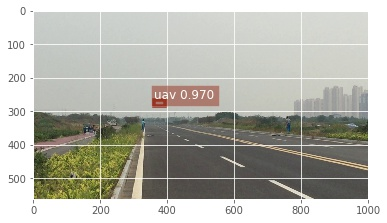

In [65]:
import time
img = '/home/sparrow/mx-rcnn/data/VOCdevkit/VOC2007/JPEGImages/000123.jpg'
img = cv2.imread(img)
img = cv2.resize(img,(1280, 720))
cv2.imwrite('/home/sparrow/mx-rcnn/sparrow/test.jpg', img)
print(img.shape)
demo_net(predictor, '/home/sparrow/mx-rcnn/sparrow/test.jpg', vis = True)

- 600*800   142 162  
- 1024*768  152 172
- 1280*720  160 180
- 1980*1080  180 201

Text(0,0.5,u'$mAP$')

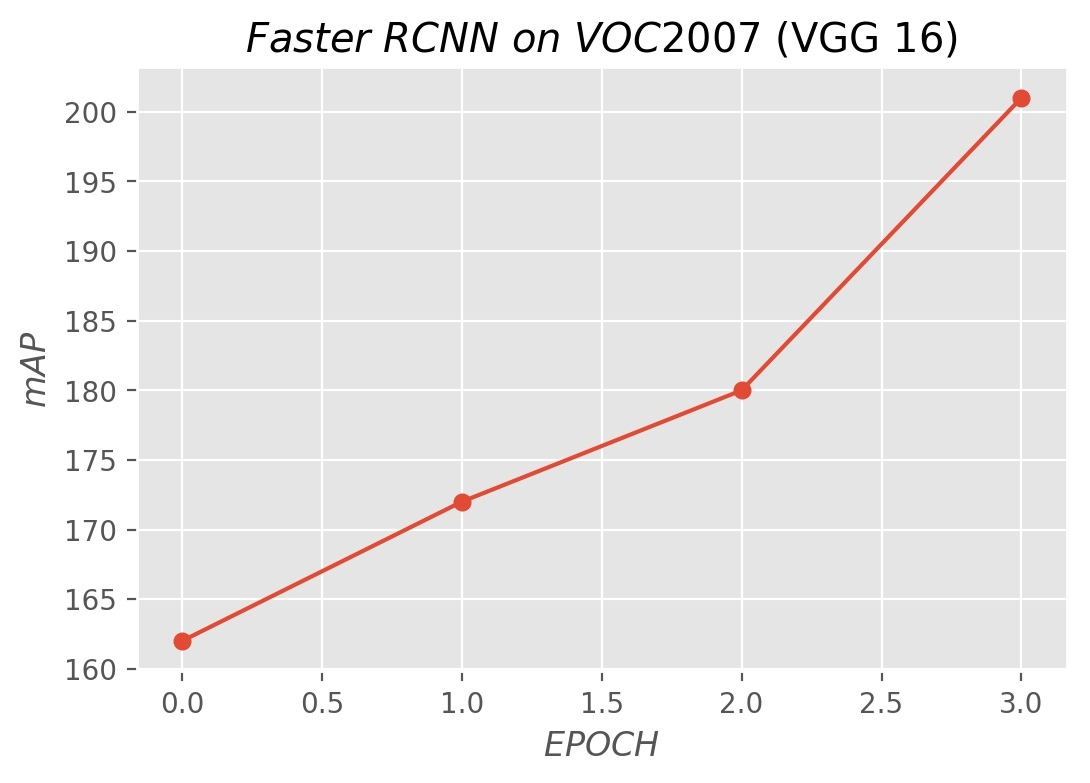

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
import os
import numpy as np
set_matplotlib_formats('jpg')

plt.style.use('ggplot')


fig = plt.figure(figsize=(6,4), dpi=200)
x = list(range(0, 4))
plt.plot(x, [162,172,180,201])
plt.scatter(x, [162,172,180,201])
#plt.legend(['STD','OHEM','Deformable ROI Pooling','Focal','STD - ROI BATCH 2048'])
plt.title('$Faster$ $RCNN$ $on$ $VOC2007$ (VGG 16)')
plt.xlabel('$EPOCH$')
plt.ylabel('$mAP$')
#plt.xticks(range(1,21))